# pMPO pipeline notebook

Important formulas used:

- pMPO aggregation (per our interpretation used in the notebook):
  $$
  \text{pMPO}=\sum_{i} w_i\,p_i(x_i)\,s_i(x_i)
  $$
  where $p_i(x)$ is the desired-class density for descriptor $i$, $s_i(x)$ is the sigmoidal desirability, and $w_i$ are normalized weights.

- Sigmoid (Eq. 2 in SI implementation):
  $$
  s(x)=\frac{1}{1 + b\, c^{-(x-x_0)}}
  $$

- Gaussian (normal) density (used for $p_i(x)$):
  $$
  p(x)=\frac{1}{\sqrt{2\pi}\sigma}\exp\!\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
  $$

- Heuristic cutoff (SI implementation; if $\mu_{des} < \mu_{not}$):
  $$
  \text{cutoff} = \frac{\mu_{not}-\mu_{des}}{\sigma_{des}+\sigma_{not}}\cdot \sigma_{des} + \mu_{des}
  $$
  and
  $$
  \text{cutoff}_{pref} = \max(\mu_{des},\,\mu_{not}-\sigma_{not}),\qquad
  \text{cutoff}_{notpref} = \max(\mu_{des}+\sigma_{des},\,\mu_{not}).
  $$

- Intersection of two normal densities $p_{des}(x)=p_{not}(x)$ leads to solving the quadratic:
  $$
  a x^2 + b x + c = 0
  $$
  with
  $$
  a = \frac{1}{\sigma_{des}^2} - \frac{1}{\sigma_{not}^2},\quad
  b = -2\frac{\mu_{des}}{\sigma_{des}^2} + 2\frac{\mu_{not}}{\sigma_{not}^2},\quad
  c = \frac{\mu_{des}^2}{\sigma_{des}^2} - \frac{\mu_{not}^2}{\sigma_{not}^2} - 2\ln\!\left(\frac{\sigma_{not}}{\sigma_{des}}\right).
  $$

- Compute $b$ from density at $x_0$:
  $$
  b = \frac{1}{p_{des}(x_0)} - 1
  $$

- Compute $c$ from desired low-level value $q_{cutoff}$ at $x_{bound}$:
  $$
  b\,c^{-(x_{bound}-x_0)} = \frac{1}{q_{cutoff}} - 1 \equiv n
  $$
  so
  $$
  c = \exp\!\left(-\frac{\ln(n/b)}{x_{bound}-x_0}\right)
  $$

- z‑score used for weighting (SI style):
  $$
  z_i = \frac{|\mu_{des,i} - \mu_{not,i}|}{\sigma_{des,i} + \sigma_{not,i}},\qquad
  w_i = \frac{z_i}{\sum_j z_j}.
  $$

In [1]:
import json
import math
from pathlib import Path
from typing import Dict, Any, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, norm
from scipy import optimize
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.calibration import calibration_curve

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

In [4]:
# Constants

CSV_PATH = "drugs_props.csv"
MODEL_JSON_PATH = "pmpo_model_params.json"
OUTPUT_DIR = Path("pmpo_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# thresholds
PVAL_THRESH = 0.05
R2_THRESH = 0.5
Q_CUTOFF = 0.05     # level for sigmoid in 'not-desired' area
MIN_SAMPLES = 5     # minimal samples per group for descriptor


In [5]:
# Load dataset

df = pd.read_csv(CSV_PATH)
# Expect columns: 'Drug', 'Smiles', 'CNS' (TRUE/FALSE), and numeric descriptor columns
df['CNS'] = df['CNS'].astype(bool)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

excluded = {'Drug', 'Smiles', 'CNS'}
descriptor_cols = [c for c in df.columns if c not in excluded and pd.api.types.is_numeric_dtype(df[c])]
print("Descriptor columns detected:", descriptor_cols)


Rows: 663
Columns: ['Drug', 'CNS', 'TPSA', 'TPSA_S', 'HBA', 'HBD', 'MW', 'nAtoms', 'cLogD_ACD_v15', 'mapKa', 'cLogP_Biobyte', 'mbpKa', 'cLogP_ACD_v15', 'ALogP98', 'Smiles']
Descriptor columns detected: ['TPSA', 'TPSA_S', 'HBA', 'HBD', 'MW', 'nAtoms', 'cLogD_ACD_v15', 'mapKa', 'cLogP_Biobyte', 'mbpKa', 'cLogP_ACD_v15', 'ALogP98']


In [6]:
# Stats, cutoffs, intersections, sigmoid params

def compute_group_stats(series: pd.Series) -> Tuple[float, float, int]:
    vals = series.dropna().values
    n = len(vals)
    if n == 0:
        return float('nan'), float('nan'), 0
    mu = float(np.mean(vals))
    sigma = float(np.std(vals, ddof=1)) if n > 1 else 0.0
    return mu, sigma, n

def compute_ttest(x: pd.Series, y: pd.Series) -> Tuple[float, float]:
    try:
        tstat, pval = ttest_ind(x.dropna(), y.dropna(), equal_var=False)
    except Exception:
        return float('nan'), float('nan')
    return tstat, pval

def find_cutoff_from_stats(mu_des, sigma_des, mu_not, sigma_not):
    if np.isnan(mu_des) or np.isnan(mu_not):
        return np.nan, np.nan, np.nan
    if mu_des < mu_not:
        cutoff = ((mu_not - mu_des) / (sigma_des + sigma_not)) * sigma_des + mu_des
        cutoff_pref = max(mu_des, mu_not - sigma_not)
        cutoff_notpref = max(mu_des + sigma_des, mu_not)
    else:
        cutoff = ((mu_des - mu_not) / (sigma_des + sigma_not)) * sigma_not + mu_not
        cutoff_pref = min(mu_not + sigma_not, mu_des)
        cutoff_notpref = max(mu_not, mu_des - sigma_des)
    return float(cutoff), float(cutoff_pref), float(cutoff_notpref)

def solve_normal_intersection(mu1, s1, mu2, s2):
    if any(np.isnan([mu1, s1, mu2, s2])):
        return []
    if s1 <= 0 or s2 <= 0:
        return []
    a = 1.0 / (2 * s1**2) - 1.0 / (2 * s2**2)
    b = mu2 / (s2**2) - mu1 / (s1**2)
    c = (mu1**2) / (2*s1**2) - (mu2**2) / (2*s2**2) - np.log(s2 / s1)
    if abs(a) < 1e-12:
        if abs(b) < 1e-12:
            return []
        x = -c / b
        return [float(x)]
    disc = b*b - 4*a*c
    if disc < 0:
        return []
    x1 = (-b + np.sqrt(disc)) / (2*a)
    x2 = (-b - np.sqrt(disc)) / (2*a)
    return [float(x1), float(x2)]

def compute_sigmoid_params_from_x0(mu_des, sigma_des, x0, x_bound, q_cutoff=Q_CUTOFF):
    if sigma_des <= 0:
        p_x0 = 1.0 if x0 == mu_des else 0.0
    else:
        p_x0 = norm.pdf(x0, loc=mu_des, scale=sigma_des)
    eps = 1e-12
    p_x0 = max(p_x0, eps)
    b = max((1.0 / p_x0) - 1.0, eps)
    n = 1.0 / q_cutoff - 1.0
    dx = x_bound - x0
    if abs(dx) < 1e-12:
        c = 1.0
    else:
        ratio = n / b
        if ratio <= 0:
            c = 1.0
        else:
            try:
                c = math.exp(- math.log(ratio) / dx)
            except Exception:
                c = 1.0
    return float(p_x0), float(b), float(c)

def sigmoid_s(x, x0, b, c):
    if c <= 0:
        return 1.0/(1.0 + b)
    return 1.0 / (1.0 + b * (c ** (-(x - x0))))


In [7]:
# Descriptor statistics and t-tests; store results

results = {}
for col in descriptor_cols:
    des = df.loc[df['CNS'], col]
    not_des = df.loc[~df['CNS'], col]
    mu_des, sd_des, n_des = compute_group_stats(des)
    mu_not, sd_not, n_not = compute_group_stats(not_des)
    tstat, pval = compute_ttest(des, not_des)
    zscore = abs(mu_des - mu_not) / (sd_des + sd_not) if (sd_des + sd_not) > 0 else 0.0
    results[col] = {
        'mu_des': mu_des, 'sd_des': sd_des, 'n_des': n_des,
        'mu_not': mu_not, 'sd_not': sd_not, 'n_not': n_not,
        'tstat': float(tstat) if not np.isnan(tstat) else None,
        'pval': float(pval) if not np.isnan(pval) else None,
        'zscore': float(zscore)
    }

res_df = pd.DataFrame(results).T
res_df = res_df.sort_values('pval')
res_df.to_csv(OUTPUT_DIR / "descriptor_stats.csv")
display(res_df)

candidates = res_df[(res_df['pval'] < PVAL_THRESH) & (res_df['n_des'] >= MIN_SAMPLES) & (res_df['n_not'] >= MIN_SAMPLES)]
print("Candidates after p-value and sample-size filter:", len(candidates))
display(candidates)


,mu_des,sd_des,n_des,mu_not,sd_not,n_not,tstat,pval,zscore
TPSA,50.831477,28.310053,298.0,86.342301,39.000644,365.0,-13.561337,4.357969e-37,0.527566
TPSA_S,55.359128,30.832046,298.0,92.556877,42.829792,365.0,-12.977590,2.039670e-34,0.504980
HBA,3.315436,1.591591,298.0,5.126027,2.436108,365.0,-11.506599,5.953449e-28,0.449535
HBD,1.090604,0.892456,298.0,2.030137,1.347228,365.0,-10.745130,7.351794e-25,0.419494
cLogP_Biobyte,6.422282,3.441009,298.0,3.984110,3.735537,365.0,8.732063,2.096111e-17,0.339742
MW,304.441921,94.254526,298.0,361.263809,134.510426,365.0,-6.377569,3.425909e-10,0.248385
nAtoms,21.590604,6.685845,298.0,25.257534,9.671215,365.0,-5.753119,1.354643e-08,0.224180
cLogP_ACD_v15,2.637624,1.769959,298.0,1.863315,1.953825,365.0,5.346893,1.238122e-07,0.207936
cLogD_ACD_v15,1.817919,1.937584,298.0,0.840247,2.854185,365.0,5.232095,2.273587e-07,0.204032
ALogP98,0.686829,0.873495,298.0,0.821438,1.086616,365.0,-1.768231,7.748367e-02,0.068674


Candidates after p-value and sample-size filter: 9


,mu_des,sd_des,n_des,mu_not,sd_not,n_not,tstat,pval,zscore
TPSA,50.831477,28.310053,298.0,86.342301,39.000644,365.0,-13.561337,4.357969e-37,0.527566
TPSA_S,55.359128,30.832046,298.0,92.556877,42.829792,365.0,-12.977590,2.039670e-34,0.504980
HBA,3.315436,1.591591,298.0,5.126027,2.436108,365.0,-11.506599,5.953449e-28,0.449535
HBD,1.090604,0.892456,298.0,2.030137,1.347228,365.0,-10.745130,7.351794e-25,0.419494
cLogP_Biobyte,6.422282,3.441009,298.0,3.984110,3.735537,365.0,8.732063,2.096111e-17,0.339742
MW,304.441921,94.254526,298.0,361.263809,134.510426,365.0,-6.377569,3.425909e-10,0.248385
nAtoms,21.590604,6.685845,298.0,25.257534,9.671215,365.0,-5.753119,1.354643e-08,0.224180
cLogP_ACD_v15,2.637624,1.769959,298.0,1.863315,1.953825,365.0,5.346893,1.238122e-07,0.207936
cLogD_ACD_v15,1.817919,1.937584,298.0,0.840247,2.854185,365.0,5.232095,2.273587e-07,0.204032


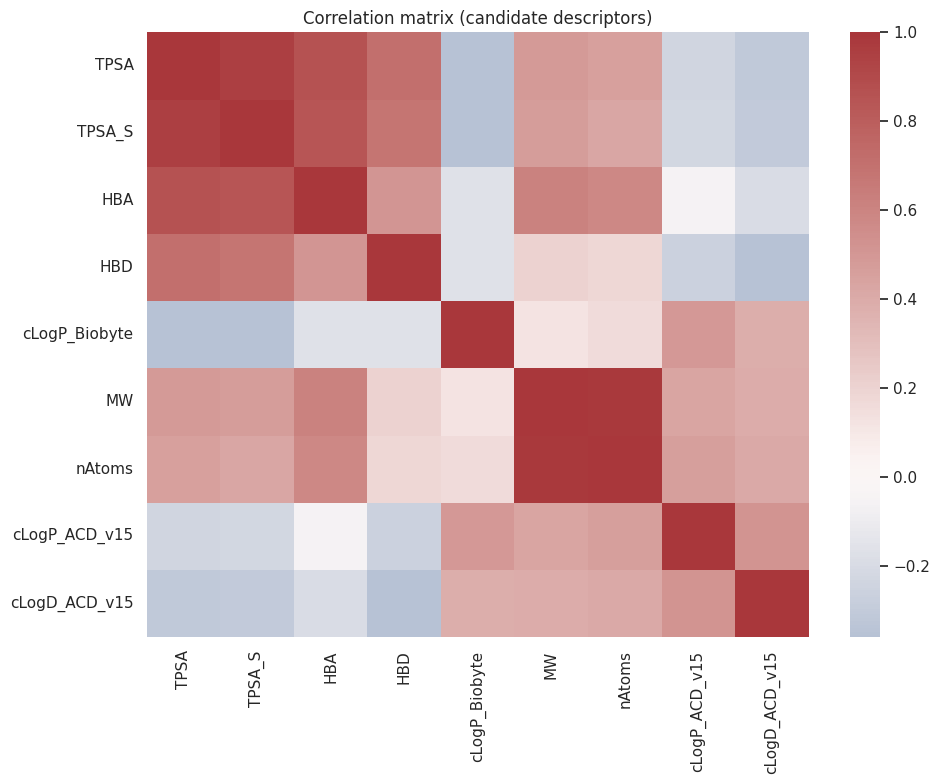

Selected descriptors after removing correlated ones: ['MW', 'TPSA', 'cLogD_ACD_v15', 'cLogP_ACD_v15', 'cLogP_Biobyte']
p-values:
TPSA :  4.357968800392579e-37
TPSA_S :  2.039669868353541e-34
HBA :  5.953449208032972e-28
HBD :  7.351794316278898e-25
cLogP_Biobyte :  2.096110827963058e-17
MW :  3.425908743691835e-10
nAtoms :  1.3546432849351147e-08
cLogP_ACD_v15 :  1.2381217083857427e-07
cLogD_ACD_v15 :  2.2735866890418388e-07


In [10]:
# Correlation matrix and pruning correlated descriptors
corr = df[candidates.index].corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='vlag', center=0)
plt.title("Correlation matrix (candidate descriptors)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "corr_matrix_candidates.png", dpi=150)
plt.show()

selected = list(candidates.index)
pvals = candidates['pval'].to_dict()

def iterative_prune_corr(cols, corrmat, pvals, r2_thresh=R2_THRESH):
    keep = set(cols)
    R2 = corrmat.loc[cols, cols].abs() ** 2
    pairs = [(i, j) for i in cols for j in cols if i != j and (i < j)]
    pairs_sorted = sorted(pairs, key=lambda pair: R2.loc[pair[0], pair[1]], reverse=True)
    for i, j in pairs_sorted:
        if i not in keep or j not in keep:
            continue
        if R2.loc[i, j] > r2_thresh:
            pi = pvals.get(i, 1.0)
            pj = pvals.get(j, 1.0)
            drop = i if pi > pj else j
            keep.discard(drop)
    return sorted(list(keep))

selected_pruned = iterative_prune_corr(selected, corr, pvals, R2_THRESH)
print("Selected descriptors after removing correlated ones:", selected_pruned)
pd.DataFrame(selected_pruned, columns=['descriptor']).to_csv(OUTPUT_DIR / "selected_descriptors.csv", index=False)

print('p-values:')

for descr, pVal in pvals.items():
  print(descr, ': ', pVal)

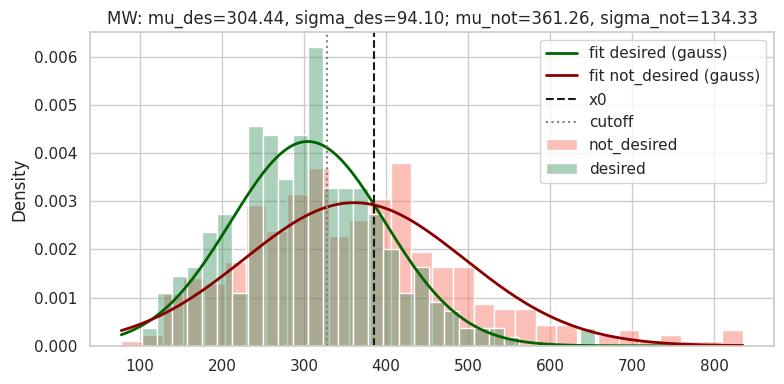

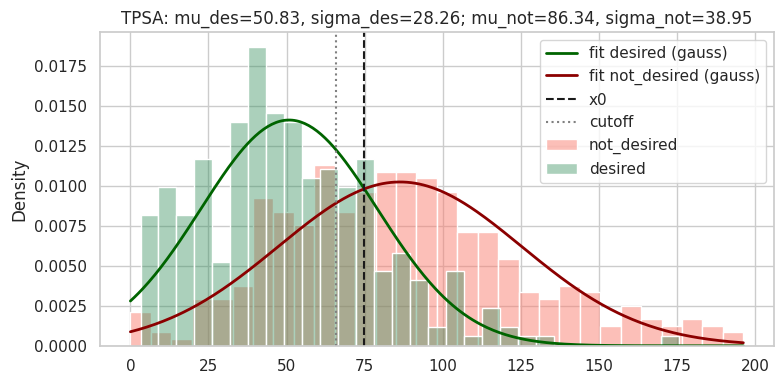

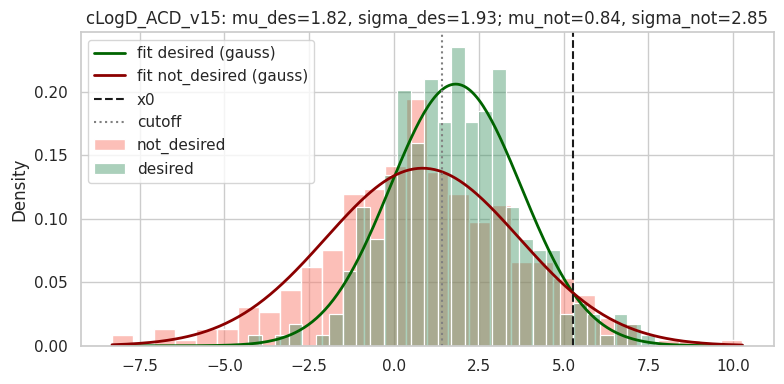

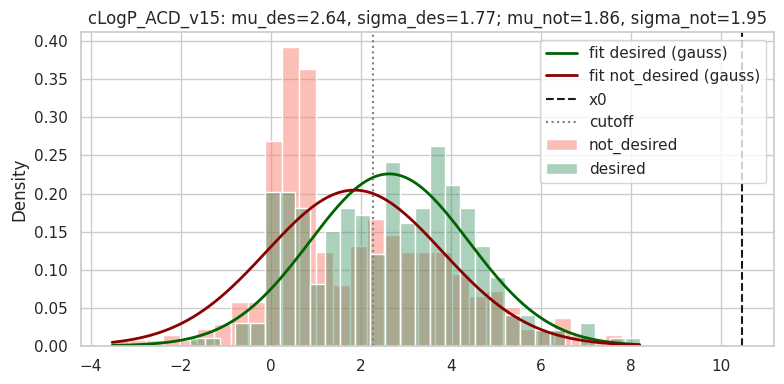

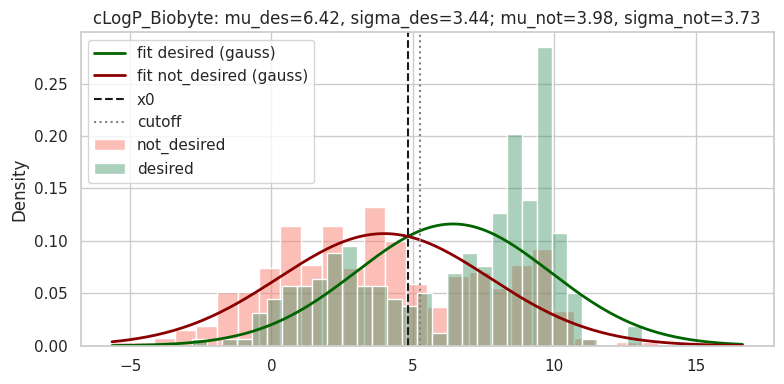

In [11]:
# Fit Gaussian densities for each selected descriptor and visualize
fit_params = {}

for col in selected_pruned:
    values_des = df.loc[df['CNS'], col].dropna().values
    values_not = df.loc[~df['CNS'], col].dropna().values

    try:
        mu_des, sigma_des = norm.fit(values_des) if len(values_des) >= 2 else (np.mean(values_des), 0.0)
    except Exception:
        mu_des, sigma_des = compute_group_stats(pd.Series(values_des))[:2]
    try:
        mu_not, sigma_not = norm.fit(values_not) if len(values_not) >= 2 else (np.mean(values_not), 0.0)
    except Exception:
        mu_not, sigma_not = compute_group_stats(pd.Series(values_not))[:2]

    cutoff, cutoff_pref, cutoff_notpref = find_cutoff_from_stats(mu_des, sigma_des, mu_not, sigma_not)
    intersections = solve_normal_intersection(mu_des, sigma_des, mu_not, sigma_not)

    x0 = None
    if intersections:
        for r in intersections:
            low = min(mu_des, mu_not)
            high = max(mu_des, mu_not)
            if low - 1e-8 <= r <= high + 1e-8:
                x0 = r
                break
        if x0 is None:
            x0 = intersections[0]
    else:
        x0 = cutoff

    x_bound = cutoff_notpref
    p_x0, b, c = compute_sigmoid_params_from_x0(mu_des, sigma_des, x0, x_bound, q_cutoff=Q_CUTOFF)

    fit_params[col] = {
        'mu_des': float(mu_des), 'sigma_des': float(sigma_des),
        'mu_not': float(mu_not), 'sigma_not': float(sigma_not),
        'cutoff': float(cutoff), 'cutoff_pref': float(cutoff_pref), 'cutoff_notpref': float(cutoff_notpref),
        'intersections': intersections,
        'x0': float(x0), 'x_bound': float(x_bound),
        'p_x0': float(p_x0), 'b': float(b), 'c': float(c)
    }

    x_min = min(np.nanmin(values_des) if len(values_des)>0 else np.nan,
                np.nanmin(values_not) if len(values_not)>0 else np.nan)
    x_max = max(np.nanmax(values_des) if len(values_des)>0 else np.nan,
                np.nanmax(values_not) if len(values_not)>0 else np.nan)
    if np.isfinite(x_min) and np.isfinite(x_max):
        xs = np.linspace(x_min, x_max, 300)
        pdf_des = norm.pdf(xs, loc=mu_des, scale=sigma_des) if sigma_des>0 else np.zeros_like(xs)
        pdf_not = norm.pdf(xs, loc=mu_not, scale=sigma_not) if sigma_not>0 else np.zeros_like(xs)

        plt.figure(figsize=(8,4))
        sns.histplot(values_not, bins=30, stat='density', color='salmon', alpha=0.5, label='not_desired')
        sns.histplot(values_des, bins=30, stat='density', color='seagreen', alpha=0.4, label='desired')
        plt.plot(xs, pdf_des, color='darkgreen', lw=2, label='fit desired (gauss)')
        plt.plot(xs, pdf_not, color='darkred', lw=2, label='fit not_desired (gauss)')
        plt.axvline(x0, color='k', linestyle='--', label='x0')
        plt.axvline(cutoff, color='gray', linestyle=':', label='cutoff')
        plt.title(f"{col}: mu_des={mu_des:.2f}, sigma_des={sigma_des:.2f}; mu_not={mu_not:.2f}, sigma_not={sigma_not:.2f}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"fit_{col}.png", dpi=150)
        plt.show()

with open(OUTPUT_DIR / "fit_params_raw.json", "w") as f:
    json.dump(fit_params, f, indent=2)


/tmp/ipython-input-646331022.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=w_df.values, y=w_df.index, palette='viridis')


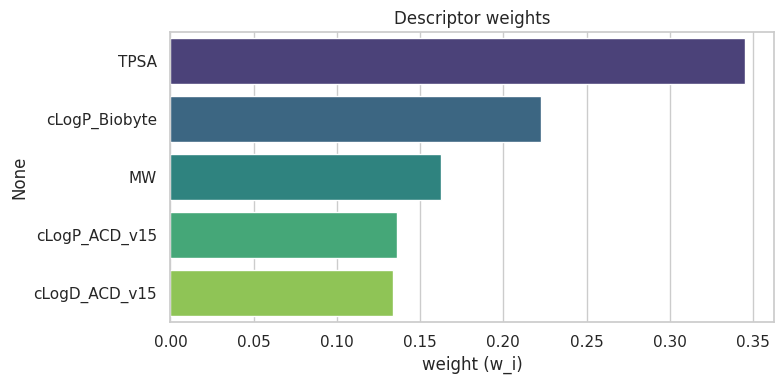

In [12]:
# Compute z-scores and weights, visualize weights
z_scores = {}
for col in selected_pruned:
    mu_des = fit_params[col]['mu_des']
    mu_not = fit_params[col]['mu_not']
    sd_des = fit_params[col]['sigma_des']
    sd_not = fit_params[col]['sigma_not']
    z = abs(mu_des - mu_not) / (sd_des + sd_not) if (sd_des + sd_not) > 0 else 0.0
    z_scores[col] = float(z)

sum_z = sum(z_scores.values()) if sum(z_scores.values())>0 else 1.0
weights = {col: float(z_scores[col] / sum_z) for col in z_scores}

for col in selected_pruned:
    fit_params[col]['z'] = float(z_scores[col])
    fit_params[col]['w'] = float(weights[col])

w_df = pd.Series(weights).sort_values(ascending=False)
plt.figure(figsize=(8, max(4, len(w_df)*0.25)))
sns.barplot(x=w_df.values, y=w_df.index, palette='viridis')
plt.xlabel('weight (w_i)')
plt.title("Descriptor weights")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "weights_bar.png", dpi=150)
plt.show()


In [14]:
# Save model parameters

model_out = {
    'meta': {
        'pval_thresh': PVAL_THRESH,
        'r2_thresh': R2_THRESH,
        'q_cutoff': Q_CUTOFF,
        'descriptor_selection_date': pd.Timestamp.now().isoformat()
    },
    'descriptors': fit_params
}
with open(MODEL_JSON_PATH, 'w') as f:
    json.dump(model_out, f, indent=2)
print("Model parameters saved to", MODEL_JSON_PATH)


Model parameters saved to pmpo_model_params.json


In [15]:
# Compute pMPO for the whole dataframe (and per-descriptor contributions)
def p_des_density(x, mu, sigma):
    if pd.isna(x):
        return 0.0
    if sigma <= 0:
        return 1.0 if x == mu else 0.0
    return float(norm.pdf(x, loc=mu, scale=sigma))

def compute_pmpo_for_dataframe(df_in: pd.DataFrame, model_params: Dict[str, Any]):
    df = df_in.copy()
    descriptor_list = list(model_params['descriptors'].keys())
    pmpos = []
    contributions = []
    for idx, row in df.iterrows():
        total = 0.0
        contrib = {}
        for desc in descriptor_list:
            x = row.get(desc, np.nan)
            params = model_params['descriptors'][desc]
            mu_des = params['mu_des']
            sd_des = params['sigma_des']
            p_i = p_des_density(x, mu_des, sd_des)
            s_i = sigmoid_s(x, params['x0'], params['b'], params['c']) if not pd.isna(x) else 0.0
            w_i = params['w']
            v = float(w_i * p_i * s_i)
            contrib[desc] = v
            total += v
        pmpos.append(float(total))
        contributions.append(contrib)
    df['pMPO'] = pmpos
    contrib_df = pd.DataFrame(contributions).fillna(0.0)
    df = pd.concat([df.reset_index(drop=True), contrib_df.reset_index(drop=True)], axis=1)
    return df

df_with_pmpo = compute_pmpo_for_dataframe(df, model_out)
df_with_pmpo.to_csv(OUTPUT_DIR / "df_with_pmpo.csv", index=False)
print("pMPO computed and saved to df_with_pmpo.csv")


pMPO computed and saved to df_with_pmpo.csv


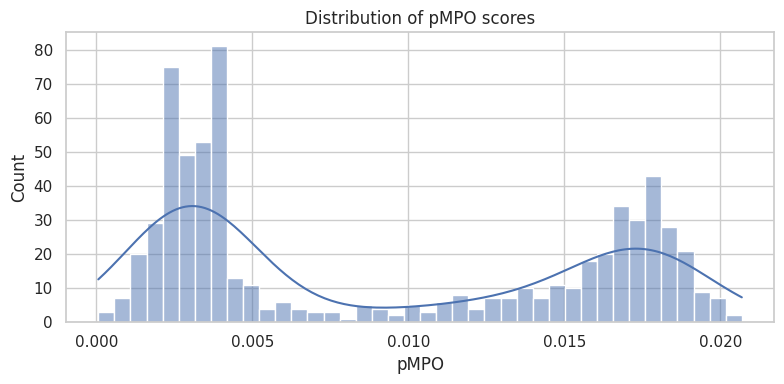

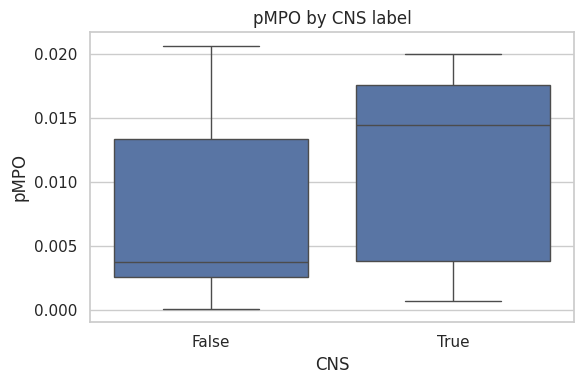

/tmp/ipython-input-188943620.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pMPO', y='Drug', data=top_df, palette='magma')


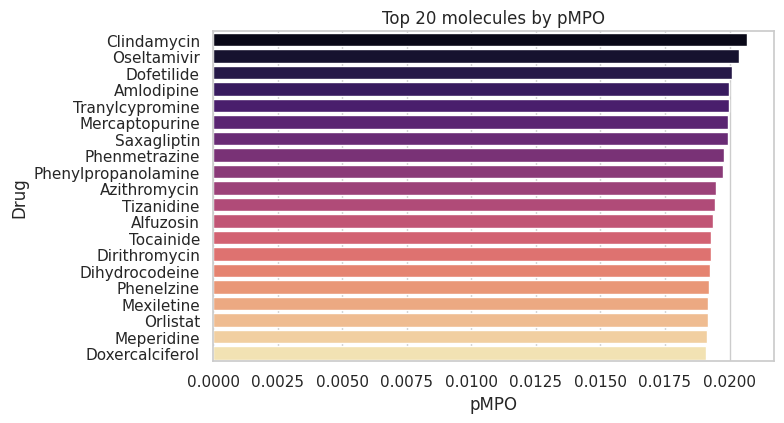

In [16]:
# Visualize pMPO distribution and top molecules

plt.figure(figsize=(8,4))
sns.histplot(df_with_pmpo['pMPO'], bins=40, kde=True)
plt.title("Distribution of pMPO scores")
plt.xlabel("pMPO")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "pmpo_hist.png", dpi=150)
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='CNS', y='pMPO', data=df_with_pmpo)
plt.title("pMPO by CNS label")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "pmpo_by_label.png", dpi=150)
plt.show()

topN = 20
top_df = df_with_pmpo.sort_values('pMPO', ascending=False).head(topN)
plt.figure(figsize=(8, max(4, topN*0.22)))
sns.barplot(x='pMPO', y='Drug', data=top_df, palette='magma')
plt.title(f"Top {topN} molecules by pMPO")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "top_molecules_pmpo.png", dpi=150)
plt.show()


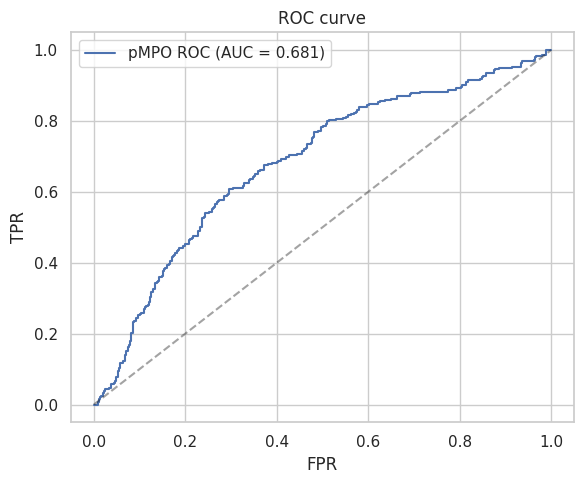

Youden best threshold: 0.01015086311407435


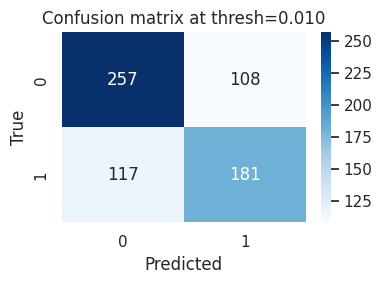

In [17]:
# ROC, AUC, choose threshold and confusion matrix

y_true = df_with_pmpo['CNS'].astype(int).values
y_scores = df_with_pmpo['pMPO'].values

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'pMPO ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "roc_pmpo.png", dpi=150)
plt.show()

youden_idx = np.argmax(tpr - fpr)
best_thresh = thresholds[youden_idx]
print("Youden best threshold:", best_thresh)

preds = (y_scores >= best_thresh).astype(int)
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion matrix at thresh={best_thresh:.3f}")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=150)
plt.show()


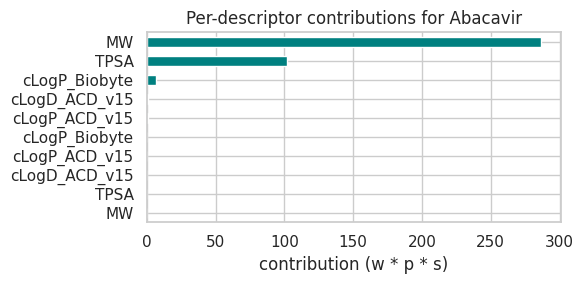

In [18]:
# Per-descriptor contributions for one example (waterfall)

example_idx = 0  # change to the index you want to inspect
example_row = df_with_pmpo.iloc[example_idx]
contrib_cols = selected_pruned
contrib_values = example_row[contrib_cols].sort_values()
plt.figure(figsize=(6, max(3, len(contrib_values)*0.3)))
contrib_values.plot.barh(color='teal')
plt.title(f"Per-descriptor contributions for {example_row.get('Drug','(unknown)')}")
plt.xlabel("contribution (w * p * s)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"waterfall_{example_row.get('Drug','sample')}.png", dpi=150)
plt.show()


/tmp/ipython-input-3078843393.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  enrich = df_with_pmpo.groupby('pmpo_bin')['CNS'].agg(['count', 'mean']).reset_index().rename(columns={'mean':'fraction_CNS','count':'n'})


,pmpo_bin,n,fraction_CNS
0,"(-0.0009354000000000001, 0.00419]",317,0.299685
1,"(0.00419, 0.00831]",45,0.466667
2,"(0.00831, 0.0124]",37,0.405405
3,"(0.0124, 0.0166]",90,0.566667
4,"(0.0166, 0.0207]",174,0.666667


/tmp/ipython-input-3078843393.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=enrich['pmpo_bin'].astype(str), y=enrich['fraction_CNS'], palette='coolwarm')


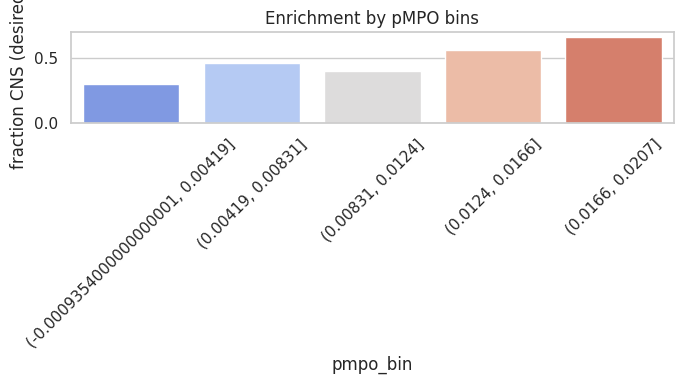

In [19]:
# Enrichment by pMPO bins (example)

bins = np.linspace(df_with_pmpo['pMPO'].min(), df_with_pmpo['pMPO'].max(), 6)
df_with_pmpo['pmpo_bin'] = pd.cut(df_with_pmpo['pMPO'], bins=bins, include_lowest=True)
enrich = df_with_pmpo.groupby('pmpo_bin')['CNS'].agg(['count', 'mean']).reset_index().rename(columns={'mean':'fraction_CNS','count':'n'})
display(enrich)

plt.figure(figsize=(7,4))
sns.barplot(x=enrich['pmpo_bin'].astype(str), y=enrich['fraction_CNS'], palette='coolwarm')
plt.xticks(rotation=45)
plt.ylabel("fraction CNS (desired)")
plt.title("Enrichment by pMPO bins")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "enrichment_pmpo_bins.png", dpi=150)
plt.show()


In [20]:
# Save final artifacts and wrap-up
df_with_pmpo.to_csv(OUTPUT_DIR / "df_with_pmpo_full.csv", index=False)
with open(OUTPUT_DIR / "pmpo_model_params.json", "w") as f:
    json.dump(model_out, f, indent=2)
print("All outputs saved to", OUTPUT_DIR)


All outputs saved to pmpo_outputs
